```python
[
    {"title": "CoT Infrastructure & Sentence Taxonomy", "icon": "1-circle-fill", "subtitle": "(30%)"},
    {"title": "Black-box Analysis", "icon": "2-circle-fill", "subtitle": "(30%)"},
    {"title": "White-box Methods", "icon": "3-circle-fill", "subtitle": "(40%)"},
]
```

# [1.6.4] Interpreting Reasoning: Thought Anchors

<img src="https://raw.githubusercontent.com/info-arena/ARENA_img/refs/heads/main/img/header-64.png" width="350">

# Introduction

In most of this chapter's content so far, we've focused on dividing up LLM computation into small steps, specifically single-token generation. We saw this in Indirect Object Identification where we deeply analyzed how GPT2-Small generates a single token, and we can also see it in other exercises like OthelloGPT. But recent models have made advances in **chain-of-thought reasoning**. When models are producing very long reasoning traces (autoregressively consuming their tokens), we have to think about not just serialized computation over layers to produce a single token, but serialized computation over a very large number of tokens. To get traction on this problem, we're going to need to introduce a new abstraction.

The paper [Thought Anchors: Which LLM Reasoning Steps Matter?](https://arxiv.org/abs/2506.19143) does this by splitting up reasoning traces by **sentence**. Compared to tokens, sentences are more coherent and correspond more closely to the actual reasoning steps taken by LLMs (e.g. see the paper [Understanding Reasoning in Thinking LMs via Steering Vectors](https://arxiv.org/abs/2506.19143), which identified behaviour categories for steps taken by reasoning models, and found them to correspond to sentences rather than tokens).

The diagram below illustrates this: we can group sentences according to a rough taxonomy of reasoning steps, and use this to show that certain kinds of sentences are more important than others in terms of shaping the trajectory of the reasoning trace (and the final answer). The authors term these sentences **thought anchors**. Thought anchors can be identified using black-box methods (i.e. resampling rollouts) or white-box methods (looking at / intervening on attention patterns). In these exercises, we'll work through both.

<img src="https://i.snipboard.io/PBoc9G.jpg" width="700">

## Content & Learning Objectives

### 1️⃣ CoT Infrastructure & Sentence Taxonomy

In this section, you'll inspect your dataset of reasoning traces, and understand the taxonomy of sentences we'll be using to classify reasoning steps. In this way, you'll build up to a better understanding of the shape of the problem we're trying to solve.

> ##### Learning Objectives
> 
> * Import & understand the structure of our reasoning dataset
> * Understand how to use regex-based heuristics and autoraters to classify sentences
> * Classify sentences in reasoning traces by taxonomy 

### 2️⃣ Black-box Analysis

Next, you'll understand the black-box methods the paper used to measure sentence importance, specifically the resampling method. This is the primary way that the paper found **thought anchors**: the critical sentences that guide the trajectory of model reasoning.

Since the paper already open-sourced their dataset which includes resampled rollouts, we'll start by analyzing these rather than generating our own, although the end of this section will include exercises on implementing your own resampling.

> ##### Learning Objectives
> 
> * Understand the baseline of **forced answer importance** used for reasoning chunks (and its limitations)
> * Learn about resampling methods for measuring sentence importance, and implement your own resampling metric calculations on a given resampled rollout
> * Learn how we can filter for low cosine similarity resamplings to find sentences which are critical for shaping the model's reasoning trajectory
> * Reproduce several of the paper's key figures analysing the importance of different categories of reasoning steps
> * Implement your own resampling methods using LLM generation

### 3️⃣ White-box Methods

Lastly, you'll look at some white-box methods for identifying thought anchors. This includes **receiver head analysis** (finding sentences which receive most attention from the model's important heads) and causal masking to test the effect of removing the weight from particular sentences.

> ##### Learning Objectives
> 
> * TODO(mcdougallc)


## Setup code

Before running this code, you'll need to clone the [thought-anchors repo](https://github.com/interp-reasoning/thought-anchors) so that it can be added to your path:

```bash
git clone https://github.com/interp-reasoning/thought-anchors.git
```

In [ ]:
import os
from datasets import load_dataset
import pandas as pd
import numpy as np
import json
import torch
import re
from transformers import AutoTokenizer, AutoModelForCausalLM, StoppingCriteria
from pathlib import Path
import seaborn as sns
import textwrap
import transformers
from collections import defaultdict
from typing import Dict
from tqdm import tqdm
from dotenv import load_dotenv
from openai import OpenAI
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import plotly.express as px
from scipy.stats import kurtosis
import plotly.graph_objects as go
from collections import Counter
import warnings
import sys
import sentence_transformers
from pprint import pprint
from huggingface_hub.utils import disable_progress_bars, enable_progress_bars
import einops
from huggingface_hub import hf_hub_download, list_repo_files

warnings.filterwarnings("ignore")


thought_anchors_path = Path.cwd().parent / "material/thought-anchors"
assert thought_anchors_path.exists()

sys.path.append(str(thought_anchors_path))

from utils import (
    # split_solution_into_chunks,
    extract_boxed_answers,
    check_answer,
    normalize_answer,
    load_math_problems,
)

# 1️⃣ CoT Infrastructure & Sentence Taxonomy


## Model Setup & Dataset Inspection

Let's start by setting a few constants:

In [ ]:
# TODO - actually use these! or delete them

# Configuration
MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
DATASET_NAME = "uzaymacar/math-rollouts"  # Pre-computed rollouts from paper
SIMILARITY_THRESHOLD = 0.8  # Median threshold from paper
EMBEDDING_MODEL = "all-MiniLM-L6-v2"  # Sentence embedding model used in paper
N_ROLLOUTS = 100  # Number of rollouts per sentence

# # Paths (adjust these to match your setup)
# ROLLOUTS_DIR = Path("math_rollouts")  # Directory with generated rollouts
# ANALYSIS_DIR = Path("analysis")  # Directory to save analysis results
# ANALYSIS_DIR.mkdir(exist_ok=True, parents=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Let's load in our embedding model. Embedding models are unsupervised models designed to take in text and output a vector - we'll be using them to classify the similarity of different sentences, so we can find motifs in our reasoning traces.

In [ ]:
embedding_model = SentenceTransformer(EMBEDDING_MODEL)
print(embedding_model)

To give you an idea of how it works, let's look at some example sentences:

In [ ]:
prompts = [
    "Wait, I think I made an error in my reasoning and need to backtrack",
    "Hold on, I believe I made a mistake in my logic and should reconsider",
    "After careful analysis, I've determined the correct answer is 42",
    "Time is an illusion. Lunchtime doubly so.",
]
labels = [x[:35] + "..." for x in prompts]

embedding = embedding_model.encode(prompts)

cosine_sims = embedding @ embedding.T

px.imshow(
    cosine_sims,
    color_continuous_scale="RdBu",
    color_continuous_midpoint=0,
    labels=dict(x="Prompt", y="Prompt", color="Cosine Similarity"),
    x=labels,
    y=labels,
)

We can also load in the dataset that the paper's authors have helpfully open-sourced. The dataset is very large, but the authors provide the structure in the corresponding [HuggingFace page](https://huggingface.co/datasets/uzaymacar/math-rollouts), so we can use the `huggingface_hub` package to load in just the data we want.

In [ ]:
# dataset = load_dataset(DATASET_NAME, split="default", streaming=True)

PROBLEM_ID = 4682

path = f"deepseek-r1-distill-llama-8b/temperature_0.6_top_p_0.95/correct_base_solution/problem_{PROBLEM_ID}/base_solution.json"

local_path = hf_hub_download(repo_id=DATASET_NAME, filename=path, repo_type="dataset")

with open(local_path, "r") as f:
    problem_data = json.load(f)

problem_data

Lastly, we'll load in the LLM we'll be using for actual reasoning trace generation. We'll be using DeepSeek-R1-Distill-Llama-8B, to match the paper's implementation as closely as possible.

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    dtype=torch.bfloat16,  # Use bfloat16 for efficiency
    device_map="auto",  # Automatically distribute across available GPUs
    trust_remote_code=True,
)
model = model.to(device)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"Model loaded on: {model.device}")
print(f"Model has {model.config.num_hidden_layers} layers")
print(f"Model has {model.config.num_attention_heads} attention heads per layer")

We can test rollouts with this model:

In [410]:
problem_data["chunk_solutions"][10][0].keys()

dict_keys(['chunk_removed', 'prefix_without_chunk', 'chunk_resampled', 'rollout', 'full_cot', 'answer', 'is_correct'])

In [ ]:
easy_problem_text = "A rectangle has a length of 8 cm and a width of 5 cm. What is its perimeter?"

easy_prompt = f"""Solve this math problem step by step.

Problem: {easy_problem_text}

Solution:
<think>"""

inputs = tokenizer(easy_prompt, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        temperature=0.6,
        top_p=0.95,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id,
    )

generated_text = tokenizer.decode(
    outputs[0][len(inputs["input_ids"][0]) :], skip_special_tokens=False
)
easy_problem_full_text = easy_prompt + generated_text

print(easy_problem_full_text)

### Exercise - add a stopping criteria

```yaml
Difficulty: 🔴🔴🔴🔴⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-15 minutes on this exercise.
```

It's a bit annoying that the model sometimes extends beyond the `</think>` token, since we might sometimes want to only take the output inside `<think> ... </think>` tags. To fix this, let's introduce a **stopping criteria**.

HuggingFace models support the `stopping_criteria` argument, which is a list of `StoppingCriteria` objects. We can implement our own `StoppingCriteria` by subclassing the base class and overriding the `__call__` method. It takes in `input_ids` (the tensor of all generated tokens so far), and it should return `True` when we want this most recent generation to be the final one.

In [ ]:
# TODO(mcdougallc) maybe we don't want this, because we want the actual answer after the CoT? idk


class StopOnThink(StoppingCriteria):
    def __call__(self, input_ids, scores, **kwargs):
        # YOUR CODE HERE: return True iff the model has generated "</think>"
        think_token_id = tokenizer.encode("</think>", add_special_tokens=False)[0]
        return input_ids[0, -1] == think_token_id


with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        temperature=0.6,
        top_p=0.95,
        do_sample=True,
        stopping_criteria=[StopOnThink()],
        pad_token_id=tokenizer.eos_token_id,
    )

generated_text = tokenizer.decode(
    outputs[0][len(inputs["input_ids"][0]) :], skip_special_tokens=False
)
easy_problem_full_text = easy_prompt + generated_text

print(easy_problem_full_text)

### Exercise - implement sentence splitting

```yaml
Difficulty: 🔴⚪⚪⚪⚪
Importance: 🔵🔵⚪⚪⚪

You should spend ~10 minutes on this exercise.
```

First, we'll need to split our CoT traces into sentences based on punctuation and paragraph indices. We'll also need to handle special tokens like `<think>`.

You should fill in the `split_solution_into_chunks` function below. We've given you a few basic tests to pass; when your solution passes all of them you can be confident you've dealt with enough edge cases. Here is the full set of rules as defined by the edge cases:

- The `<think> ... </think>` tags should be removed
- You should split on sentences (i.e. ending in any of `.`, `!`, `?`, or newlines), and characters like `: `
- If the period `.` is in a decimal or numbered list (e.g. `34.5` or `\n1.`) then you shouldn't split on it
- You should split on periods `.` unless they are decimal numbers e.g. `x.y` or a numbered list e.g. `\n1.`
- No chunk should have length less than 10: if so, then merge it with the next chunk
- Each chunk should be stripped of whitespace

This is a bit of a grunt task, so feel free to use LLMs to help you!

In [ ]:
def split_solution_into_chunks(text: str) -> list[str]:
    """Split solution into sentence-level chunks."""

    # YOUR CODE HERE - fill in the rest of the function

    # Remove thinking tags
    if "<think>" in text:
        text = text.split("<think>")[1]
    if "</think>" in text:
        text = text.split("</think>")[0]
    text = text.strip()

    # Replace the "." characters which I don't want to split on
    text = re.sub(r"(\d)\.(\d)", r"\1<DECIMAL>\2", text)  # e.g. "4.5" -> "4<DECIMAL>5"
    text = re.sub(r"\n(\d)\.(\s)", r"\n\1<DECIMAL>\2", text)  # e.g. "1.\n" -> "\n1<DECIMAL>"

    # Split on sentence endings, and combine the endings with the previous chunk
    sentences = re.split(r"([!?:\n]|(?<!\n\d)\.)", text)
    chunks = []
    for i in range(0, len(sentences) - 1, 2):
        chunks.append((sentences[i] + sentences[i + 1]).replace("\n", " "))

    # Replace <DECIMAL> back with "."
    chunks = [re.sub(r"<DECIMAL>", ".", c) for c in chunks]

    # Merge chunks that are too short
    while len(chunks) > 1 and min([len(x) for x in chunks[:-1]]) < 10:
        for i, chunk in enumerate(chunks[:-1]):
            if len(chunk) < 10:
                chunks = chunks[:i] + [chunk + chunks[i + 1]] + chunks[i + 2 :]
                break

    return [c.strip() for c in chunks if c.strip()]


test_cases = [
    # (input_text, expected_chunks)
    (
        "<think>First, I understand the problem. Next, I'll solve for x. Finally, I verify!</think>",
        ["First, I understand the problem.", "Next, I'll solve for x.", "Finally, I verify!"],
    ),
    (
        "<think>Let me break this down: 1. Convert to decimal. 2. Calculate log. 3. Apply formula.</think>",
        [
            "Let me break this down:",
            "1. Convert to decimal.",
            "2. Calculate log.",
            "3. Apply formula.",
        ],
    ),
    (
        "<think>The formula is A = πr². Wait. No. Actually, it's different.</think>",
        ["The formula is A = πr².", "Wait. No.", "Actually, it's different."],
    ),
    (
        "<think>Convert 66666₁₆ to decimal. This equals 419,430. How many bits? We need log₂(419,430) ≈ 18.7. So 19 bits!</think>",
        [
            "Convert 66666₁₆ to decimal.",
            "This equals 419,430.",
            "How many bits?",
            "We need log₂(419,430) ≈ 18.7.",
            "So 19 bits!",
        ],
    ),
    ("<think>The answer is 42. Done.</think>", ["The answer is 42.", "Done."]),
]

for input_text, expected_chunks in test_cases:
    chunks = split_solution_into_chunks(input_text)
    assert chunks == expected_chunks, f"Expected {expected_chunks}, got {chunks}"

## Sentence categorization

Now that we've created a method for splitting up our reasoning traces into chunks, we can work out how to categorize them.

The [paper](https://arxiv.org/abs/2506.19143) uses a taxonomy of 8 different categories:

1. **Problem Setup**: Parsing or rephrasing the problem
2. **Plan Generation**: Stating or deciding on a plan of action, meta-reasoning
3. **Fact Retrieval**: Recalling facts, formulas, problem details
4. **Active Computation**: Algebra, calculations, manipulations
5. **Uncertainty Management**: Expressing confusion, re-evaluating, backtracking
6. **Result Consolidation**: Aggregating intermediate results, summarizing
7. **Self Checking**: Verifying previous steps, checking calculations
8. **Final Answer Emission**: Explicitly stating the final answer

There are 2 approaches usually taken for this kind of classification: heuristic-based (using regexes or keyword matching) and LLM-based (i.e. using an **autorater**). We'll try both, so we can compare the results. 

### Exercise - heuristic-based categorization

```yaml
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-15 minutes on this exercise.
```

First, we'll implement a heuristic-based approach. You should do the following:

- Fill out the `CATEGORY_WORDS` dictionary below, which maps each category to a list of words associated with that category. To get you started, we've filled out the first three categories.
- Fill out the `categorize_sentences_heuristic` function below, which uses this dictionary to categorize sentences. We've given you a few example sentences to test your function - at minimum make sure your function works for these.

Once you've passed the test sentences below, you should try taking rollouts from your model above (or examples from the dataset) and see how your function performs on them. Some questions you might ask yourself:

- Do you think this taxonomy is reasonable?
- Are there any sentences that are misclassified, or belong to more than one category?
- How many words do you need to add before your classification works decently?

Note that no heuristic-based classification will be perfect. The point of this exercise is to get you thinking about the different categories, and what the strengths / limitations of this kind of method are. In research, you should generally try not to reach for a tool more complicated than what you need!

In [ ]:
CATEGORIES = {
    "problem_setup": "Problem Setup",
    "plan_generation": "Plan Generation",
    "fact_retrieval": "Fact Retrieval",
    "active_computation": "Active Computation",
    "uncertainty_management": "Uncertainty Management",
    "result_consolidation": "Result Consolidation",
    "self_checking": "Self Checking",
    "final_answer_emission": "Final Answer Emission",
    "unknown": "Unknown",
}

CATEGORY_WORDS = {
    # Note: we put the most definitive categories first, so they override the later ones
    "final_answer_emission": ["\\boxed", "final answer"],
    "problem_setup": ["need to", "problem is", "given"],
    "fact_retrieval": ["remember", "formula", "know that", "recall"],
    "active_computation": ["calculate", "compute", "solve", "=", "equals", "result", "giving"],
    "uncertainty_management": ["wait", "let me", "double check", "hmm", "actually", "reconsider"],
    "result_consolidation": ["summarize", "so", "therefore", "in summary"],
    "self_checking": ["verify", "check", "confirm", "correct"],
    "plan_generation": ["plan", "approach", "strategy", "will", "i'll", "try"],
}


def categorize_sentences_heuristic(chunks: list[str]) -> list[str]:
    """
    Categorize sentences using heuristics/keyword matching (simplified version).

    For full LLM-based labeling, see prompts.py DAG_PROMPT in the thought-anchors repo.

    Args:
        sentences: List of sentence strings

    Returns:
        List of tags.
    """

    categories = []

    for idx, chunk in enumerate(chunks):
        chunk_lower = chunk.lower()

        if idx == 0:
            tag = "problem_setup"
        else:
            for category, words in CATEGORY_WORDS.items():
                if any(word in chunk_lower for word in words):
                    tag = category
                    break
            else:
                tag = "unknown"

        categories.append(CATEGORIES.get(tag))

    return categories


example_problem_text = "What is the area of a circle with radius 5?"

example_sentences, example_categories = list(
    zip(
        *[
            ("I need to find the area of a circle with radius 5.", "Problem Setup"),
            ("The formula for circle area is A = πr².", "Fact Retrieval"),
            ("Substituting r = 5: A = π × 5² = 25π.", "Active Computation"),
            ("Wait, let me look again at that calculation.", "Uncertainty Management"),
            ("So the area is 25π square units.", "Result Consolidation"),
            ("Therefore, the answer is \\boxed{25π}.", "Final Answer Emission"),
        ]
    )
)

categories = categorize_sentences_heuristic(example_sentences)

for sentence, category, expected_category in zip(example_sentences, categories, example_categories):
    assert category == expected_category, (
        f"Expected {expected_category!r}, got {category!r} for sentence: {sentence!r}"
    )


Now, testing your function on an actual rollout, does it look reasonable? If not, you can try going back and tweaking the categories or the categorization logic.

In [ ]:
easy_chunks = split_solution_into_chunks(easy_problem_full_text)

easy_categories = categorize_sentences_heuristic(easy_chunks)

for chunk, category in zip(easy_chunks, easy_categories):
    chunk_str = chunk if len(chunk) < 80 else chunk[:60] + " ... " + chunk[-20:]
    print(f"{category:>20} | {chunk_str!r}")


### Exercise - implement an autorater

```yaml
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-15 minutes on this exercise.
```

We'll now progress to a slightly more advanced approach for classification, using an **autorater**. This essentially means we're querying an LLM to do the categorization for us, rather than relying on hardcoded rules.

We'll start by setting up a helper function to call an API (to keep things simple we're sticking with OpenAI for now, but this could easily be modified to support other providers). It has the option of returning in structured output, which can be helpful for classification tasks.

You'll need to create an `.env` file in the current working directory and set the `OPENAI_API_KEY` environment variable, then you can run the cell below to see how the helper function works.

In [ ]:
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

openai_client = OpenAI(api_key=OPENAI_API_KEY) if OPENAI_API_KEY else None


def generate_api_response(
    model: str = "gpt-4.1-mini",
    messages: list[dict[str, str]] = [],
    max_tokens: int = 128,
    stop_sequences: list[str] | None = None,
    temperature: float = 0.0,
    max_retries: int = 3,
) -> str:
    """Helper function with retry logic and error handling."""

    for attempt in range(max_retries):
        try:
            # Generate response
            resp = openai_client.chat.completions.create(
                model=model,
                messages=messages,
                max_tokens=max_tokens,
                temperature=temperature,
                stop=stop_sequences if stop_sequences else None,
            )
            # Extract text from response
            return resp.choices[0].message.content or ""

        except Exception as e:
            if "rate_limit_error" in str(e) or "429" in str(e):
                if attempt < max_retries - 1:
                    # Exponential backoff: 2^attempt seconds (1, 2, 4, 8, 16...)
                    wait_time = 2**attempt
                    print(f"Rate limit hit, waiting {wait_time} seconds before retry...")
                    time.sleep(wait_time)
                    continue
                else:
                    print(f"Failed to get response after {max_retries} attempts, returning early.")
            raise e


resp = generate_api_response(messages=[{"role": "user", "content": "Who are you?"}])

print(textwrap.fill(resp))

Note the default use of temperature zero in the autorater above. This is because we're looking for reproducibility and reliability; we don't benefit from output diversity in this case. A temperature of zero is also useful for reproducibility.

We've also given you the prompt we'll use for the autorater - it's a simplified version of the `DAG_SYSTEM_PROMPT` in the author's file `thought-anchors/prompts.py`. Note that the authors allow for a chunk to receive multiple tags; we assume a single tag per chunk to keep things simple.

In [ ]:
DAG_SYSTEM_PROMPT = """
You are an expert in interpreting how language models solve math problems using multi-step reasoning. Your task is to analyze a Chain-of-Thought (CoT) reasoning trace, broken into discrete text chunks, and label each chunk with a tag that describes what this chunk is *doing* functionally in the reasoning process.

---

### Function Tags:

1. `problem_setup`: 
    Parsing or rephrasing the problem (initial reading or comprehension).
    
2. `plan_generation`: 
    Stating or deciding on a plan of action, or on the next step in the reasoning process.
    
3. `fact_retrieval`: 
    Recalling facts, formulas, problem details (without immediate computation).
    
4. `active_computation`: 
    Performing algebra, calculations, manipulations toward the answer.
    This only includes actual calculations being done & values computed, not stating formulas or plans.
    
5. `result_consolidation`: 
    Aggregating intermediate results, summarizing, or preparing final answer.
    
6. `uncertainty_management`: 
    Expressing confusion, re-evaluating, proposing alternative plans (includes backtracking).
    
7. `final_answer_emission`: 
    Explicit statement of the final boxed answer or earlier chunks that contain the final answer.
    
8. `self_checking`: 
    Verifying previous steps, Pythagorean checking, re-confirmations.
    This is at the object-level, whereas "uncertainty_management" is at the planning level.

9. `unknown`: 
    Use only if the chunk does not fit any of the above tags or is purely stylistic or semantic.

---

### Output Format:

Return a numbered list, one item for each chunk, consisting of the function tag that best describes the chunk.

For example:

1. problem_setup
...
5. final_answer_emission
"""

You should now complete the function `categorize_sentences_autorater` below, which will use the `DAG_SYSTEM_PROMPT` and the `generate_api_response` function we've already written to categorize the chunks. You'll need to supply your own user prompt to go with the system prompt above.

In [ ]:
def categorize_sentences_autorater(problem_text: str, chunks: list[str]) -> list[str]:
    """
    Categorize sentences using heuristics/keyword matching (simplified version).

    Args:
        sentences: List of sentence strings

    Returns:
        List of categories.
    """

    # YOUR CODE HERE

    chunk_str = ""
    for i, chunk in enumerate(chunks):
        chunk_str += f"{i + 1}. {chunk}\n"

    user_prompt = f"""
Here is the math problem:

[PROBLEM]
{problem_text}

Here is the full Chain of Thought, broken into chunks:

[CHUNKS]
{chunk_str.strip()}

Now label each chunk with function tags and dependencies."""

    raw_response = generate_api_response(
        messages=[
            {"role": "system", "content": DAG_SYSTEM_PROMPT},
            {"role": "user", "content": user_prompt},
        ],
    )
    response = re.split(r"\n\d{1,2}\.", "\n" + raw_response.strip())
    response = [r.strip() for r in response if r.strip()]

    assert len(response) == len(chunks), f"Length mismatch: {len(response)} != {len(chunks)}"

    return [CATEGORIES.get(r, "Unknown") for r in response]

You can run the cell below to see how your function performs on the example sentences. Does it agree with the heuristic-based approach? Do you think it's better or worse? You can also try it on the rollouts you generated earlier.

In [ ]:
example_categories = categorize_sentences_autorater(example_problem_text, example_sentences)

for chunk, category in zip(example_sentences, example_categories):
    print(f"{category:>25} | {chunk!r}")

In [ ]:
easy_categories_autorater = categorize_sentences_autorater(easy_problem_text, easy_chunks)

df = pd.DataFrame(
    {
        "Category (heuristics)": easy_categories,
        "Category (autorater)": easy_categories_autorater,
        "Chunk": easy_chunks,
    }
)
with pd.option_context("display.max_colwidth", None):
    display(df)

Before moving to the next section, we'll make a helper function to visualize reasoning traces:


In [ ]:
CATEGORY_COLORS = {
    "Problem Setup": "#4285F4",
    "Plan Generation": "#EA4335",
    "Fact Retrieval": "#FBBC05",
    "Active Computation": "#34A853",
    "Uncertainty Management": "#9C27B0",
    "Result Consolidation": "#00BCD4",
    "Self Checking": "#FF9800",
    "Final Answer Emission": "#795548",
    "Unknown": "#9E9E9E",
}


def visualize_trace_structure(chunks: list[str], categories: list[str], problem_text: str = None):
    """Visualize a reasoning trace with color-coded sentence categories."""

    n_chunks = len(chunks)
    fig, ax = plt.subplots(figsize=(12, 1 + int(0.5 * n_chunks)))

    for idx, (chunk, category) in enumerate(zip(chunks, categories)):
        color = CATEGORY_COLORS.get(category, "#9E9E9E")

        y = n_chunks - idx  # Start from top

        # Category label with colored background
        ax.barh(y, 0.15, left=0, height=0.8, color=color, alpha=0.6)
        ax.text(0.075, y, f"{category}", ha="center", va="center", fontsize=9, weight="bold")

        # Sentence text
        text = chunk[:100] + ("..." if len(chunk) > 100 else "")
        ax.text(0.17, y, f"[{idx}] {text}", va="center", fontsize=9)

    ax.set_xlim(0, 1)
    ax.set_ylim(0.5, n_chunks + 0.5)
    ax.axis("off")

    if problem_text:
        fig.suptitle(f"Problem: {problem_text[:120]}...", fontsize=11, y=0.98, weight="bold")

    plt.title("Reasoning Trace Structure", fontsize=13, pad=30)
    plt.tight_layout()
    plt.show()


visualize_trace_structure(easy_chunks, easy_categories, easy_problem_text)


# 2️⃣ Black-box Analysis

The paper used three different methods to measure sentence importance:

**1. Forced Answer Importance**. For each sentence $S_i$ in the CoT, we interrupt the model and append text, inducing a final output: `Therefore, the final answer is \\boxed{...}`. We then measure the model's accuracy when forced to answer immediately. If $A^f_i$ is the final answer when we force the model to answer immediately after $S_i$, and $P(A)$ is the probability of answer $A$ being correct, then the formula for forced answer importance is:

$$
\text{importance}_f := P(A^f_i) - P(A^f_{i-1})
$$

<details>
<summary>Can you see a flaw in this approach, when it comes to identifying sentences which are critical for the model's reasoning process? Click here to reveal the answer.</summary>

Some sentence $S$ might be necessary for the final answer, but comes late in the reasoning process, meaning all sentences before $S$ will result in low accuracy by this metric. We will only pick up sentences whose inclusion *in combination with all previous sentences* gets us from the wrong answer to the right one.

For people who have completed the IOI material / done much work with model internals, this is the equivalent of finding the most important model components by seeing which ones write the final answer to the residual stream. It's a good start, but doesn't tell you much about the steps of the computation beyond the last one.

</details>

**2. Resampling Importance**. To address the flaw above, for each sentence $S_i$ in the CoT, we can resample a whole trajectory $(S_1, S_2, \ldots, S_{i-1}, S_i, S'_{i+1}, ..., S'_N, A^r_i)$ (where $A^r_i$ is the final answer we get from resampling chunks after $S_i$). By comparing it to the corresponding trajectory $(S_1, S_2, \ldots, S'_i, ..., S'_{N}, A^r_i)$ which we get from resampling chunks including $S_i$, we can get a sense for how important $S_i$ was for producing the final answer. Our metric is:

<!-- D_{\text{KL}} -->
<!-- \,\|\, -->

$$
\text{importance}_r := P(A^r_i) - P(A^r_{i-1})
$$

**3. Counterfactual Importance**. An issue with resampling importance is that often $S'_i$ will be very similar to $S_i$, if the reasoning context strongly constraints what can be expressed at that position. To fix this, we can filter for cases where these two sentences are fairly different, using a semantic similarity metric derived from our embedding model. This gives us a counterfactual importance metric which is identical to the previous one, but just with filtered rollouts:

$$
\text{importance} := P(A^c_i) - P(A^c_{i-1})
$$

In these sections, we'll work through each of these metrics in turn. The focus will be computing these metrics **on the dataset we've already been provided**, with the full replication (including your own implementation of resampling) coming in the next section.

## Looking closer at our dataset

Before getting into the exercises, let's look closer at our dataset to see what we're working with. As mentioned, we'll be setting aside our actual model and chunking functions temporarily, so we can focus on analysing the resampled rollouts already provided to us in this dataset.

The code below loads in all the data necessary for analyzing a single problem. This contains:

- `problem` which contains the problem statement, along with some basic metadata (including the answer)
- `chunks_labeled[i]`, data for the `i`-th chunk (e.g. what category it is, plus some metrics)
- `chunk_solutions_forced[i][j]`, data for the `j`-th rollout we get from forcing an answer immediately after the `i`-th chunk (e.g. for `i=0` this means forcing an answer before any chunks are included)
- `chunk_solutions[i][j]`, data for the `j`-th rollout we get from resampling immediately after the `i`-th chunk

We'll be using this data to implement the three importance metrics described above.

### Exercise - inspect the dataset

```yaml
Difficulty: 🔴⚪⚪⚪⚪
Importance: 🔵🔵⚪⚪⚪

You should spend up to 10-15 minutes on this exercise.
```

Run the code below to load in the data for a single problem (note we're using generations from `deepseek-r1-distill-qwen-14b` rather than our Llama-8b model here, so that we match the case study in the paper's appendix).

Make sure you understand the structure of the data, since this will make the following exercises easier. 

Here are a few investigative questions you might try to answer when inspecting this problem's data:

- How has the chunking worked here? Can you see any obvious issues with how it's been applied, e.g. places where a chunk has been split that shouldn't have been?
- Do the categories look reasonable? You can try comparing them to each of your autoraters, and see what fraction match.
- Inspect `chunk_solutions_forced`, and see how early the model generally manages to get the answer correct.
- Inspect `chunk_solutions`, and see how much variety the model's completions have when resampled from various stages in the reasoning process.

In [ ]:
def load_single_file(file_path: str):
    local_path = hf_hub_download(repo_id=DATASET_NAME, filename=file_path, repo_type="dataset")
    with open(local_path, "r") as f:
        return json.load(f)


def load_problem_data(problem_id: int, verbose: bool = True):
    disable_progress_bars()

    problem_dir = "correct_base_solution"
    problem_dir_forced = "correct_base_solution_forced_answer"

    problem_path = f"deepseek-r1-distill-qwen-14b/temperature_0.6_top_p_0.95/{problem_dir}/problem_{problem_id}"
    problem_path_forced = f"deepseek-r1-distill-qwen-14b/temperature_0.6_top_p_0.95/{problem_dir_forced}/problem_{problem_id}"

    base_solution = load_single_file(f"{problem_path}/base_solution.json")
    problem = load_single_file(f"{problem_path}/problem.json")
    chunks_labeled = load_single_file(f"{problem_path}/chunks_labeled.json")
    chunk_solutions = []
    chunk_solutions_forced = []

    for chunk_idx in tqdm(range(len(chunks_labeled)), disable=not verbose):
        chunk_solutions.append(load_single_file(f"{problem_path}/chunk_{chunk_idx}/solutions.json"))
        chunk_solutions_forced.append(
            load_single_file(f"{problem_path_forced}/chunk_{chunk_idx}/solutions.json")
        )

    enable_progress_bars()

    return {
        "problem": problem,
        "base_solution": base_solution,
        "chunks_labeled": chunks_labeled,
        "chunk_solutions_forced": chunk_solutions_forced,
        "chunk_solutions": chunk_solutions,
    }


problem_data = load_problem_data(PROBLEM_ID)

In [ ]:
print(problem_data["problem"])
print()

for i, c in enumerate(problem_data["chunks_labeled"]):
    print(f"{i}. {c['chunk']!r}")

### Exercise - calculating answer importance

```yaml
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵⚪⚪⚪

You should spend up to 10-15 minutes on this exercise.
```

You should fill in the function below, to compute the forced answer importance on a set of chunks and their labelled categories. Note that the function takes a list of lists of full CoT rollouts, meaning you'll need to parse out the model's answer from the CoT yourself.

Note, the model's return type can vary: for example in a question about interest rates with the answer `6.17`, the model sometimes responds with e.g. `6.17%` or `r = 6.17`. In this case study we're dealing with a problem that has an integer solution so this isn't really an issue, but it's still good practice to handle these kinds of cases when you're parsing the answer.

In [ ]:
def calculate_answer_importance(full_cot_list: list[list[str]], answer: str) -> list[float]:
    """
    Calculate importance for chunks, based on accuracy differences.

    Args:
        full_cot_list: List of resampled rollouts; the [i][j]-th element is the j-th rollout which
          was generated by answer-forcing immediately after the i-th chunk (e.g. the [0][0]-th
          element is the 0th rollout which doesn't include any chunks of the model's reasoning).
        answer: The ground truth answer to the problem.
        chunk_idx: Index of the chunk to calculate importance for.

    Returns:
        float: Forced importance score
    """

    def extract_answer_from_cot(cot: str) -> str:
        answer = cot.split("\\boxed{")[-1].split("}")[0]
        return "".join(char for char in answer if char.isdigit() or char == ".")

    # Get list of P(A_{S_i}) values for each chunk
    probabilities = [
        sum(extract_answer_from_cot(cot) == answer for cot in cot_list) / len(cot_list)
        for cot_list in full_cot_list
    ]

    # Convert these to importance scores: P(A_{S_i}) - P(A_{S_{i-1}})
    return np.diff(probabilities).tolist()

When you've done this, run the cell below to get your results and plot them. Note, this should **not**  match the paper's "Figure 2" results, since we're using forced answer importance, not resampled or counterfactual importance.

What do you notice about these results? What sentences are necessary for the model to start getting greater-than-zero accuracy? Are there any sentences which significantly drop or raise the model's accuracy, and can you explain why?

<details>
<summary>Answer - what you should see</summary>

The model starts getting greater-than-zero accuracy around chunk 40, when it computes the number of digits in the final answer. The accuracy drops significantly in a couple of spots, including near the very end when it says "That's 20 bits". The accuracy immediately recovers after this, because the next chunk clarifies that the answer is actually 19 bits because the leading digit is zero. Some of the other sharp negative spikes in accuracy are also due to this dropping-leading-zero confusion being raised then resolved in the following chunk.

Note, a discrepancy between your results and those in the dataset is fine. The current version of the dataset that is uploaded seems to have a bug in the "forced answer" metric data, for example it will classify the following rollout:

```
'Therefore, the final answers is \\boxed{20}. However, upon re-examining ... so the correct answer is \\boxed{19}.'
```

as having a final answer of `20` rather than `19`, hence incorrectly classifying the answer as wrong.

</details>

In [ ]:
full_cot_list = [
    [rollout["full_cot"] for rollout in chunk_rollouts]
    for chunk_rollouts in problem_data["chunk_solutions_forced"]
]
answer = problem_data["problem"]["gt_answer"]

forced_answer_importances = calculate_answer_importance(full_cot_list, answer)
forced_answer_importances_cumsum = np.cumsum(forced_answer_importances)
forced_answer_importances_cumsum += 1 - forced_answer_importances_cumsum[-1]

df = pd.DataFrame(
    {
        "Forced answer importance": forced_answer_importances,
        "Accuracy": forced_answer_importances_cumsum,
        "chunk": [d["chunk"] for d in problem_data["chunks_labeled"][:-1]],
        "tags": [d["function_tags"][0] for d in problem_data["chunks_labeled"][:-1]],
    }
)

fig = px.line(
    df,
    labels={"index": "Chunk index", "value": "Importance", "variable": "Metric"},
    y=["Forced answer importance", "Accuracy"],
    hover_data=["chunk", "tags"],
)
fig.update_layout(title="Forced answer importance")
fig.show()

### Exercise - compare resampled answer importance

```yaml
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-15 minutes on this exercise.
This doesn't involve changing any code, just running the cells below and interpreting the results.
```

Now that we've implemented the `answer_importance` function, we get get the resampled answer importance for free by just applying it to a different set of rollouts. You can run the cells below, which are lightly adapted versions of the cells above (just based on the resampled trajectories rather than the forced-answer trajectories).

<!-- Note that in this case we can compare the results to the precomputed values in the loaded dataset, since these seem to have been computed correctly. -->

How do these answers compare to the forced answer importance? Are there specific sentences which have higher metric scores here than in the forced answer case? Can you reproduce the results from the paper, in section **2.4 Case Study**, and do you understand the paper's description of why we get those results?

In [ ]:
full_cot_list = [
    [rollout["full_cot"] for rollout in chunk_rollouts]
    for chunk_rollouts in problem_data["chunk_solutions"]
]
answer = problem_data["problem"]["gt_answer"]

resampling_answer_importances = calculate_answer_importance(full_cot_list, answer)

resampling_answer_importances_precomputed = [
    chunk_data["resampling_importance_accuracy"]
    for chunk_data in problem_data["chunks_labeled"][:-1]
]

avg_diff = np.abs(
    np.subtract(resampling_answer_importances, resampling_answer_importances_precomputed)
).mean()
assert avg_diff < 0.01, f"Your implementation may be incorrect: {avg_diff=:.4f}"
print(f"Average difference: {avg_diff:.4f}")


In [ ]:
resampling_answer_importances_cumsum = np.cumsum(resampling_answer_importances)
resampling_answer_importances_cumsum += 1 - resampling_answer_importances_cumsum[-1]

df = pd.DataFrame(
    {
        "Resampling answer importance": resampling_answer_importances,
        "Accuracy": resampling_answer_importances_cumsum,
        "chunk": [d["chunk"] for d in problem_data["chunks_labeled"][:-1]],
        "tags": [d["function_tags"][0] for d in problem_data["chunks_labeled"][:-1]],
    }
)

fig = px.line(
    df,
    labels={"index": "Chunk index", "value": "Importance", "variable": "Metric"},
    y=["Resampling answer importance", "Accuracy"],
    hover_data=["chunk", "tags"],
)
fig.update_layout(title="Resampling answer importance")
fig.show()

### Semantic similarity in resampling

Before we look at the last metric (counterfactual importance), let's revisit the notion of embedding cosine similarity. Since we have data on a bunch of resampled rollouts at different chunks, we can compute the average cosine similarity between a chunk and all of its resampled chunks (i.e. $S_i$ and $S'_i$ in the notation above). Run the cells below to compute these cosine similarities and plot them.


Which kinds of sentences seem like their resamples have the highest or lowest cosine similarity? Can you explain why? Click on the dropdown below to see the answer.

<details>
<summary>Answer</summary>

You should find that some of the highest average cosine simlarities are for:

- **Final Answer Emission** chunks, which makes sense since there's only a limited number of ways to express an answer (and given the context, it's likely obvious whether the model is about to emit an answer, as well as what the answer will be)
- **Active Computation** and **Result Consolidation** chunks, especially those which come in batches (e.g. chunks 23-33, 51-59, and 91-97 in the plot below). This makes sense, since these chunks often involve a series of similar steps (e.g. applying an iterative formula, or doing a series of multiplications with different inputs), and once the model starts one of these processes it'll be very constrained in how it acts until it's finished.

Some of the lowest average cosine similarities are for:

- **Plan Generation** chunks which represent changes in trajectory, for example:
  - Chunk 13: "Alternatively, maybe I can calculate..."
  - Chunk 49: "Let me convert it step by step again", which is a decision to fix a theorized error earlier in reasoning
- **Uncertainty Management** chunks which also represent a re-evaluation and could change the subsequent trajectory, for example:
  - Chunk 45: "I must have made a mistake somewhere"
  - Chunk 84: "So, which is correct?"
  - Chunk 139: "Wait, but that's not correct because..."

*Note, there is one chunk (28) which is classified as "result consolidation" and is something of an outlier, with extremely low average cosine similarity to its resamples. However, inspection of `problem_data["chunk_solutions"][28]` shows that this is actually an artifact of incorrect chunking: the resamples here all follow the pattern `"Now, adding all these up:"` followed by an equation, and this has low similarity to the original chunk which (correctly) splits at `:` and so doesn't include the equation. If you want to fix this, you can try using our `split_solution_into_chunks` function from earlier to process the resampled chunks before plotting them. Moral of the story - this kind of string parsing is finnicky and easy to get wrong.*

</details>

In [429]:
# Get the embeddings of S_i, the chunks we'll be resampling
chunks_removed = [chunk_data["chunk"] for chunk_data in problem_data["chunks_labeled"]]
embeddings_S_i = embedding_model.encode(chunks_removed)  # (N_chunks, d_embed)

# Get the embeddings of T_i, the resampled chunks
chunks_resampled = [
    [rollout["chunk_resampled"] for rollout in chunk_rollouts]
    for chunk_rollouts in problem_data["chunk_solutions"]
]
embeddings_T_i = np.stack(
    [embedding_model.encode(r) for r in chunks_resampled]
)  # (N_chunks, N_resamples, d_embed)

# Get the cosine similarities
cos_sims = einops.einsum(
    embeddings_S_i, embeddings_T_i, "chunk d_embed, chunk resample d_embed -> chunk resample"
)
print(f"Computed cosine similarities for {cos_sims.shape[0]} chunks, {cos_sims.shape[1]} resamples")

Computed cosine similarities for 145 chunks, 100 resamples


In [430]:
# Group the cosine similarity data into a dataframe
cos_sims_mean = cos_sims.mean(axis=1)
chunk_labels = [CATEGORIES[chunk["function_tags"][0]] for chunk in problem_data["chunks_labeled"]]
df = pd.DataFrame(
    {
        "Label": chunk_labels,
        "Cosine similarity": cos_sims_mean,
        "chunk": [chunk["chunk"] for chunk in problem_data["chunks_labeled"]],
    }
)

# Bar chart of average cosine similarity for each chunk
px.bar(
    df,
    labels={"index": "Chunk index", "value": "Cosine similarity"},
    color="Label",
    color_discrete_map=CATEGORY_COLORS,
    hover_data=["chunk"],
    title="Cosine similarity between removed and resampled chunks",
).show()

# Boxplot of cosine cosine similarities grouped by chunk label
label_order = df.groupby("Label")["Cosine similarity"].mean().sort_values().index.tolist()
px.box(
    df,
    x="Label",
    y="Cosine similarity",
    labels={"x": "Label", "y": "Cosine similarity", "color": "Label"},
    color="Label",
    color_discrete_map=CATEGORY_COLORS,
    category_orders={"Label": label_order},
    boxmode="overlay",
    width=1000,
    title="Cosine similarity, grouped by chunk label",
).update_xaxes(tickangle=45).update_layout(boxgap=0.3).show()

### Exercise - compute counterfactual importance

```yaml
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-20 minutes on this exercise.
```

Finally, we'll implement **counterfactual importance**. This is the same as the resampling importance (and we'll use the same data), but with one difference: we filter out all resampled rollouts where the first resampled chunk $T_i$ is sufficiently different from the chunk $S_i$ which it replaces. In this case, sufficiently different means having an **embedding cosine similarity of less than 0.8**, using our embedding model from earlier.

The intuition for this metric: if resampling importance told us the effect when we choose a different sentence than $S_i$, then counterfactual importance tells us the effect when we **choose a different reasoning path than represented by $S_i$**. Low cosine similarity in this case is a proxy for the reasoning paths being very different (rather than just light rephrasings of what is essentially the same reasoning step).

In [ ]:
def calculate_counterfactual_answer_importance(
    chunks_removed: list[str],
    chunks_resampled: list[list[str]],
    full_cot_list: list[list[str]],
    answer: str,
    threshold: float = 0.8,
    min_indices: int = 5,
    embedding_model: sentence_transformers.SentenceTransformer = embedding_model,
) -> list[float]:
    """
    Calculate importance for chunks, based on accuracy differences, after filtering for low
    new-generation cosine similarity.

    Args:
        chunks_removed: List of chunks $S_i$ which were removed from the rollouts.
        chunks_resampled: List of chunks $T_i$ which were resampled for each of the multiple rollouts.
        full_cot_list: List of resampled rollouts; the [i][j]-th element is the j-th rollout which
          was generated by answer-forcing immediately after the i-th chunk (e.g. the [0][0]-th
          element is the 0th rollout which doesn't include any chunks of the model's reasoning).
        answer: The ground truth answer to the problem.
        threshold: Minimum embedding cosine similarity to consider a rollout as "sufficiently different"
        min_indices: Minimum number of indices we can have post-filtering to count this score.
        embedding_model: Embedding model to use for calculating cosine similarity

    Returns:
        float: Forced importance score
    """

    def get_filtered_indices(chunk_removed: str, chunks_resampled: list[str]) -> list[int]:
        embedding_S_i = embedding_model.encode(chunk_removed)  # (d_embed,)
        embeddings_T_i = embedding_model.encode(chunks_resampled)  # (N, d_embed,)
        cos_sims = embedding_S_i @ embeddings_T_i.T  # (N,)
        return np.where(cos_sims < threshold)[0]

    def extract_answer_from_cot(cot: str) -> str:
        answer = cot.split("\\boxed{")[-1].split("}")[0]
        return "".join(char for char in answer if char.isdigit() or char == ".")

    filtered_indices = [
        get_filtered_indices(chunk_removed, _chunks_resampled)
        for chunk_removed, _chunks_resampled in zip(chunks_removed, chunks_resampled)
    ]

    # Get list of P(A^c_{S_i}) values for each chunk (or None if can't be computed)
    probabilities = [
        sum(extract_answer_from_cot(cot_list[idx]) == answer for idx in indices) / len(indices)
        if len(indices) >= min_indices
        else None
        for cot_list, indices in zip(full_cot_list, filtered_indices)
    ]

    # Forward-fill this list, to remove the "None" values
    probabilities = pd.Series(probabilities).ffill().bfill().tolist()

    # Return diffs
    return np.diff(probabilities).tolist()

When you've filled this in, run the cells below to compute and plot the counterfactual importance scores next to your resampling importance scores.

You should find the two metrics (resampling and counterfactual) are mostly quite similar for this example. They differ most in sentences which were also shown from the plot above to have high semantic variance, because these are our **thought anchors**: sentences which guide the entire reasoning process, and so changing them to something different in embedding space has a large effect on the subsequent trajectory.

For example, chunk 3 *"So, maybe I can just figure out how many hexadecimal digits there are..."* has a higher counterfactual importance than resampling importance (93% vs 88% accuracy when you resample counterfactually vs without filtering at this chunk). This is because
the chunk represents a key part of the overall reasoning process: when the model doesn't say this, it often expresses a different plan such as *"So, maybe I can start by converting each digit one by one..."* or *"So maybe I can just multiply the number of hex digits by 4..."*. Even if some of these plans will end up at the same place, the exact plan & phrasing that the model produces in this step will significantly affect its trajectory. 

However, many of the chunks have very similar counterfactual and resampling importance scores. Only by doing a much larger statistical analysis would we be able to parse out any meaningful differences between the two (ideally we'd include more sequences and more resamples per sequence).

<!-- 
- **Chunks 43 and 44: "Now, according to this, it's 19 bits. There's a discrepancy here.** Chunk 43 has a more negative counterfactual importance than resampled importance, and inspection of resampling at chunk 43 reveals that *half the time here the model says something like "it's 19 bits" and half the time it jumps straight to saying "there's a discrepancy here"*. So the counterfactual resampling captures the fact that when the model *doesn't* say "it's 19 bits", it's more likely to say "there's a discrepancy here" which leads into eventually rejecting the 
- **Chunk 28: "Now, adding these all up:".** As we discussed in the dropdown above, this was an outlier because an apparent chunking bug, so we don't need to pay it too much mind here.
-->

<!--
- Chunks 53-58: this is a series of active computations. The counterfactual metric should be zero on most or all of these chunks, because all resampled rollouts will have had very similar semantic entropy (the model was essentially forced at this point to carry out a multi-stage computation in a very specific way). This shows our counterfactual metric is working as intended, because we want to identify these kinds of reasoning steps as not particularly important.

- Chunk 68, Uncertainty management: **"Wait, but 66666 in hex is 5 digits, so 5 * 4 = 20 bits."** This is more important in the counterfactual metric, because this is a key anchor point where the model might run with its revised 20 bit answer or change to 19 bits. -->

In [500]:
chunks_removed = [chunk_data["chunk"] for chunk_data in problem_data["chunks_labeled"]]
chunks_resampled = [
    [rollout["chunk_resampled"] for rollout in chunk_rollouts]
    for chunk_rollouts in problem_data["chunk_solutions"]
]
full_cot_list = [
    [rollout["full_cot"] for rollout in chunk_rollouts]
    for chunk_rollouts in problem_data["chunk_solutions"]
]
answer = problem_data["problem"]["gt_answer"]

counterfactual_answer_importances = calculate_counterfactual_answer_importance(
    chunks_removed, chunks_resampled, full_cot_list, answer
)

counterfactual_answer_importances_precomputed = [
    -chunk_data["counterfactual_importance_accuracy"]
    for chunk_data in problem_data["chunks_labeled"][:-1]
]

avg_diff = np.abs(
    np.subtract(counterfactual_answer_importances, counterfactual_answer_importances_precomputed)
).mean()
assert avg_diff < 0.1, f"Your implementation may be incorrect: {avg_diff=:.4f}"
print(f"Average difference: {avg_diff:.4f}")


Average difference: 0.0202


In [433]:
counterfactual_answer_importances_cumsum = np.cumsum(counterfactual_answer_importances)
counterfactual_answer_importances_cumsum += 1 - counterfactual_answer_importances_cumsum[-1]

df = pd.DataFrame(
    {
        "Resampling answer importance": resampling_answer_importances,
        "Resampling answer importance (accuracy)": resampling_answer_importances_cumsum,
        "Counterfactual answer importance": counterfactual_answer_importances,
        "Counterfactual answer importance (accuracy)": counterfactual_answer_importances_cumsum,
        "chunk": [d["chunk"] for d in problem_data["chunks_labeled"][:-1]],
        "tags": [d["function_tags"][0] for d in problem_data["chunks_labeled"][:-1]],
    }
)

fig = px.line(
    df,
    labels={"index": "Chunk index", "value": "Importance", "variable": "Metric"},
    y=[
        "Resampling answer importance",
        "Resampling answer importance (accuracy)",
        "Counterfactual answer importance",
        "Counterfactual answer importance (accuracy)",
    ],
    hover_data=["chunk", "tags"],
)
fig.update_layout(title="Resampling vs counterfactual answer importance")
fig.show()

### Exercise - replicate Figure 3b (without KL divergence)

```yaml
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵⚪⚪⚪

You should spend up to 10-15 minutes on this exercise.
```

As an open-ended challenge, try replicating Figure 3b from the paper. We've already got all the data you need to do this, so it's just a matter of understanding and plotting the data correctly.

Note that we've so far defined our metrics in terms of accuracy rather than KL divergence, so you should expect to see the metrics looking slightly different (also we're only averaging over a single prompt's chunks rather than over many prompts). We recommend leaving the error bars off, for that reason. But even with these restrictions, you should still be able to get a qualitatively similar plot to Figure 3b. We leave it as an exercise to the reader to scale up the analysis to many different prompts, and add the error bars back!

<!--

The next 2 cells do this at scale, with error bars. Note, this will take about 10 minutes to run (most of that time is spent loading the data).

```
# Get the list of all files in the data directory

files = list_repo_files(repo_id=DATASET_NAME, repo_type="dataset")
print(len(files))
# -> 29030

problem_ids = set()
for file in files:
    if match := re.search(r"/problem_(\d+)/", file):
        problem_ids.add(int(match.group(1)))
problem_ids = sorted(problem_ids)
print(problem_ids)
# -> [330, 1591, 2050, 2137, 2189, 2236, 2238, 2870, 3360, 3448, 3550, 3916, 3935, 4019, 4164, 4605, 4682, 6481, 6596, 6998]

chunk_labels_all = []
counterfactual_importances_all = []

for problem_id in tqdm(problem_ids[:10]):
    # Load data
    data = load_problem_data(problem_id)

    # Compute counterfactual importance for all chunks in this problem
    chunk_labels = [CATEGORIES[chunk["function_tags"][0]] for chunk in data["chunks_labeled"]]
    chunks_removed = [chunk_data["chunk"] for chunk_data in data["chunks_labeled"]]
    chunks_resampled = [
        [rollout["chunk_resampled"] for rollout in chunk_rollouts]
        for chunk_rollouts in data["chunk_solutions"]
    ]
    full_cot_list = [
        [rollout["full_cot"] for rollout in chunk_rollouts]
        for chunk_rollouts in data["chunk_solutions"]
    ]
    answer = data["problem"]["gt_answer"]

    counterfactual_answer_importances = calculate_counterfactual_answer_importance(
        chunks_removed, chunks_resampled, full_cot_list, answer
    )

    # Add them to the lists
    chunk_labels_all.append(chunk_labels)
    counterfactual_importances_all.append(counterfactual_answer_importances)

# Plotting all of them together:
all_data = []
for i, (labels, importances) in enumerate(zip(chunk_labels_all, counterfactual_importances_all)):
    n = len(labels)
    for j, (label, importance) in enumerate(zip(labels, importances)):
        all_data.append({"Label": label, "Importance": importance, "position": j / n})

df_all = pd.DataFrame(all_data)

# Get the 5 most common labels
top_5_labels = df_all["Label"].value_counts().head(5).index.tolist()
df_filtered = df_all[df_all["Label"].isin(top_5_labels)]

# Group and calculate mean and standard error
grouped = (
    df_filtered.groupby("Label")
    .agg({"Importance": ["mean", "sem"], "position": ["mean", "sem"]})
    .reset_index()
)
grouped.columns = ["Label", "importance_mean", "importance_sem", "pos_mean", "pos_sem"]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
for _, row in grouped.iterrows():
    ax.errorbar(
        row["pos_mean"],
        row["importance_mean"],
        xerr=row["pos_sem"],
        yerr=row["importance_sem"],
        fmt="o",
        label=row["Label"],
        color=CATEGORY_COLORS.get(row["Label"]),
        markersize=10,
        capsize=5,
    )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Normalized position in trace (0-1)")
ax.set_ylabel("Counterfactual importance")
ax.set_title("Sentence category effect")
ax.legend()
plt.show()

-->

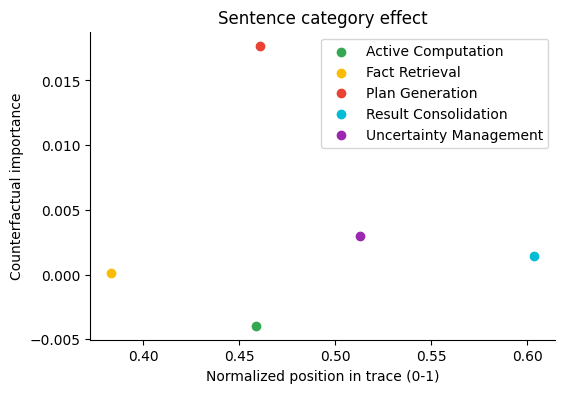

In [487]:
# Get the 5 most common labels
label_counts = pd.Series(chunk_labels[:-1]).value_counts()
top_5_labels = label_counts.head(5).index.tolist()

# Create dataframe and filter
df_filtered = pd.DataFrame(
    {
        "Label": chunk_labels[:-1],
        "Importance": counterfactual_answer_importances,
        "position": np.arange(len(chunk_labels[:-1])) / len(chunk_labels[:-1]),
    }
)
df_filtered = df_filtered[df_filtered["Label"].isin(top_5_labels)]
grouped = df_filtered.groupby("Label")[["Importance", "position"]].mean().reset_index()

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
for label in grouped["Label"]:
    row = grouped[grouped["Label"] == label]
    ax.scatter(row["position"], row["Importance"], label=label, color=CATEGORY_COLORS.get(label))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Normalized position in trace (0-1)")
ax.set_ylabel("Counterfactual importance")
ax.set_title("Sentence category effect")
ax.legend()
plt.show()

### Exercise - replicate Figure 3b (with KL divergence)

```yaml
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵⚪⚪⚪⚪

You should spend up to 10-30 minutes on this exercise, if you choose to complete it.
```

Now, you can try to replicate this figure using KL divergence instead of accuracy!

So far we've only been working with accuracy, i.e. how much does the model's tendency to say the correct answer change when we resample a particular chunk. But if we care about **how much a sentence shapes the model's trajectory** rather than just how much it helps the model get to the correct answer, then it makes sense to look at an absolute measure of how much the answers change. KL divergence is the perfect tool for looking at the difference between two distributions.

In the cells below, you should rewrite the `calculate_counterfactual_answer_importance` function to use KL divergence instead of accuracy. In other words, the `i`-th output of your function should be the KL div between the distribution of answers when the `i`-th and `i-1`-th chunks are removed: $D(p(A^c_i) \,||\, p(A^c_{i-1}))$. Some notes on this:
  
- When computing the KL divergence, your distributions can be over the discrete set of answers produced by resamplings at either the `i`-th or `i-1`-th chunk.
- To avoid division-by-zero errors, you should use the paper's method of **Laplace smoothing**: we add some value `alpha` to all the answer counts, so that when we convert them to distributions none of them are zero. The terms in our KL div calculation change from $p \log \frac{p}{q}$ to $p \log \frac{p'}{q'}$ where $p', q'$ are the smoothed distributions (meaning the terms will still be zero when $p$ is zero). We've given you the `alpha` parameter in the function signature.

You can generate the same scatter plot as above, and see if the results more closely match Figure 3b from the paper. You can also regenerate the plot from the previous exercise, and compare the two metrics (KL div based vs accuracy based). Do you see any differences? 

<details>
<summary>Answer - what you should expect to see</summary>

In my implementation, the two scatter plots look almost identical (although obviously the axis is different since all KL divergence values are non-negative*). 

The line plot was also quite similar, the main difference being that the KL divergence based metric was less noisy, i.e. more separation between the large metric spikes and the smaller values. This makes sense, since KL divergence is a convex function: an increase in the difference between two probability distributions will lead to a greater than proportional increase in the KL divergence. For example, the difference between the KL divergence of the two distributions `(0.5, 0.5)` and `(0.1, 0.9)` is more than twice the difference between `(0.5, 0.5)` and `(0.3, 0.7)`.

*Technically they can be negative thanks to the Laplace smoothing, but only very close to zero, and the group means will all be positive.

</details>

In [513]:
def calculate_counterfactual_answer_importance_kl_div(
    chunks_removed: list[str],
    chunks_resampled: list[list[str]],
    full_cot_list: list[list[str]],
    threshold: float = 0.8,
    min_indices: int = 5,
    alpha: int = 1,
    embedding_model: sentence_transformers.SentenceTransformer = embedding_model,
) -> list[float]:
    """
    Calculate importance for chunks, based on accuracy differences, after filtering for low
    new-generation cosine similarity.

    Args:
        chunks_removed: List of chunks $S_i$ which were removed from the rollouts.
        chunks_resampled: List of chunks $T_i$ which were resampled for each of the multiple rollouts.
        full_cot_list: List of resampled rollouts; the [i][j]-th element is the j-th rollout which
          was generated by answer-forcing immediately after the i-th chunk (e.g. the [0][0]-th
          element is the 0th rollout which doesn't include any chunks of the model's reasoning).
        threshold: Minimum embedding cosine similarity to consider a rollout as "sufficiently different"
        min_indices: Minimum number of indices we can have post-filtering to count this score.
        alpha: Laplace smoothing parameter
        embedding_model: Embedding model to use for calculating cosine similarity

    Returns:
        float: Forced importance score
    """
    counter = 0

    def kl_div(answers_1: list[str], answers_2: list[str]) -> float:
        nonlocal counter
        counter += 1
        if not answers_1 or not answers_2:
            return 0.0
        # Get vocab set
        vocab = set(answers_1) | set(answers_2)
        # Get counts & probabilities
        count_1 = Counter(answers_1)
        count_2 = Counter(answers_2)
        p_1 = {k: v / sum(count_1.values()) for k, v in count_1.items()}
        # Laplace smoothing
        count_1_smoothed = {k: count_1.get(k, 0) + alpha for k in vocab}
        count_2_smoothed = {k: count_2.get(k, 0) + alpha for k in vocab}
        p_1_smoothed = {k: v / sum(count_1_smoothed.values()) for k, v in count_1_smoothed.items()}
        p_2_smoothed = {k: v / sum(count_2_smoothed.values()) for k, v in count_2_smoothed.items()}
        # Get KL divergence
        return sum(p_1[k] * np.log(p_1_smoothed[k] / p_2_smoothed[k]) for k in p_1)

    def get_filtered_indices(chunk_removed: str, chunks_resampled: list[str]) -> list[int]:
        embedding_S_i = embedding_model.encode(chunk_removed)  # (d_embed,)
        embeddings_T_i = embedding_model.encode(chunks_resampled)  # (N, d_embed,)
        cos_sims = embedding_S_i @ embeddings_T_i.T  # (N,)
        return np.where(cos_sims < threshold)[0]

    def extract_answer_from_cot(cot: str) -> str:
        answer = cot.split("\\boxed{")[-1].split("}")[0]
        return "".join(char for char in answer if char.isdigit() or char == ".")

    filtered_indices = [
        get_filtered_indices(chunk_removed, _chunks_resampled)
        for chunk_removed, _chunks_resampled in zip(chunks_removed, chunks_resampled)
    ]

    # Get a list of the different answers returned in each of the resampled (filtered) rollouts
    all_answers = [
        [extract_answer_from_cot(cot_list[idx]) for idx in indices]
        if len(indices) >= min_indices
        else []
        for cot_list, indices in zip(full_cot_list, filtered_indices)
    ]

    # Get KL divergences using the function defined above
    kl_divs = [kl_div(a1, a0) for a1, a0 in zip(all_answers[1:], all_answers)]

    return kl_divs

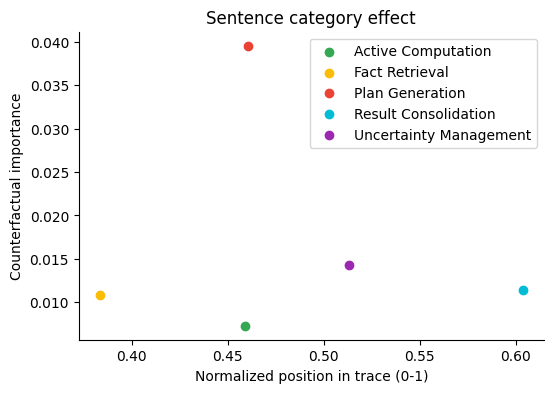

In [514]:
# Get the new KL div-based importance scores
chunk_labels = [CATEGORIES[chunk["function_tags"][0]] for chunk in problem_data["chunks_labeled"]]
chunks_removed = [chunk_data["chunk"] for chunk_data in problem_data["chunks_labeled"]]
chunks_resampled = [
    [rollout["chunk_resampled"] for rollout in chunk_rollouts]
    for chunk_rollouts in problem_data["chunk_solutions"]
]
full_cot_list = [
    [rollout["full_cot"] for rollout in chunk_rollouts]
    for chunk_rollouts in problem_data["chunk_solutions"]
]
counterfactual_answer_importances_kl_div = calculate_counterfactual_answer_importance_kl_div(
    chunks_removed, chunks_resampled, full_cot_list
)

# Re-run the plotting code from above
label_counts = pd.Series(chunk_labels[:-1]).value_counts()
top_5_labels = label_counts.head(5).index.tolist()
df_filtered = pd.DataFrame(
    {
        "Label": chunk_labels[:-1],
        "Importance": counterfactual_answer_importances_kl_div,
        "position": np.arange(len(chunk_labels[:-1])) / len(chunk_labels[:-1]),
    }
)
df_filtered = df_filtered[df_filtered["Label"].isin(top_5_labels)]
grouped = df_filtered.groupby("Label")[["Importance", "position"]].mean().reset_index()
fig, ax = plt.subplots(figsize=(6, 4))
for label in grouped["Label"]:
    row = grouped[grouped["Label"] == label]
    ax.scatter(row["position"], row["Importance"], label=label, color=CATEGORY_COLORS.get(label))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Normalized position in trace (0-1)")
ax.set_ylabel("Counterfactual importance")
ax.set_title("Sentence category effect")
ax.legend()
plt.show()

In [503]:
df = pd.DataFrame(
    {
        "Counterfactual answer importance": counterfactual_answer_importances,
        "Counterfactual answer importance (KL div)": counterfactual_answer_importances_kl_div,
        "chunk": [d["chunk"] for d in problem_data["chunks_labeled"][:-1]],
        "tags": [d["function_tags"][0] for d in problem_data["chunks_labeled"][:-1]],
    }
)

fig = px.line(
    df,
    labels={"index": "Chunk index", "value": "Importance", "variable": "Metric"},
    y=[
        "Counterfactual answer importance",
        "Counterfactual answer importance (KL div)",
    ],
    hover_data=["chunk", "tags"],
)
fig.update_layout(title="Resampling vs counterfactual answer importance")
fig.show()

## Resampling

We'll now move onto the final part of this section, where you get to implement your own resampling method for producing rollouts like the ones we've been analyzing above. 

### Exercise - implement your own resampling method

```yaml
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵⚪⚪

You should spend up to 10-20 minutes on this exercise.
```

We'll start by implementing the `resample_rollouts` function below. This function takes in a full chain of thought, and a list of chunks. It then outputs a list of lists of dicts, where `output[i][j]` contains the data for the `j`-th resampled rollout after the `i`-th chunk. These dicts should have the following keys:

- `full_cot`: The full new chain of thought for this rollout, including the chunk.
- `chunk_resampled`: The first chunk of the resampled rollout (you can find this with your `split_solution_into_chunks` function).
- `chunk_replaced`: The chunk that was replaced.

Note that this solution will probably be hackier than the more carefully designed generation & chunking code used in the actual paper, but this is fine - the purpose here is just to get an MVP which works and we could build on if we wanted to.

In [ ]:
def get_resampled_rollouts(
    prompt: str,
    num_resamples_per_chunk: int = 100,
    batch_size: int = 4,
    max_new_tokens: int = 2048,
    up_to_n_chunks: int | None = None,
    model: transformers.models.llama.modeling_llama.LlamaForCausalLM = model,
) -> tuple[str, list[str], list[list[dict]]]:
    """
    After each chunk in `chunks`, computes a number of resampled rollouts.

    Args:
        prompt: The initial problem prompt (which ends with a <think> tag).
        num_resamples_per_chunk: Number of resamples to compute for each chunk.

    Returns:
        Tuple of (full_answer, chunks, resampled_rollouts) where the latter is a list of lists of
        dicts (one for each chunk & resample on that chunk).
    """

    @torch.inference_mode()
    def generate(inputs):
        return model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.6,
            top_p=0.95,
            do_sample=True,
            stopping_criteria=[StopOnThink()],
            pad_token_id=tokenizer.eos_token_id,
        )

    # First, generate a completion which we'll split up into chunks.
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    output = generate(inputs)
    full_answer = tokenizer.decode(
        output[0, inputs["input_ids"].shape[1] :], skip_special_tokens=False
    )
    chunks = split_solution_into_chunks(full_answer)

    # Second, generate resamples at each chunk.
    chunk_rollouts = []
    n_chunk_instances = defaultdict(int)
    for chunk in tqdm(chunks[:up_to_n_chunks]):
        chunk_rollouts.append([])

        # To get the answer before the chunk, we split on the correct instance of the chunk (since
        # this chunk might have appeared multiple times in the answer).
        n_chunk_instances[chunk] += 1
        full_answer_split = (
            prompt
            + chunk.join(full_answer.split(chunk, maxsplit=n_chunk_instances[chunk])[:-1]).strip()
        )
        inputs = tokenizer([full_answer_split] * batch_size, return_tensors="pt").to(device)

        for _ in range(num_resamples_per_chunk // batch_size):
            output_batch = generate(inputs)
            for output_generation in output_batch:
                generated_text = tokenizer.decode(
                    output_generation[inputs["input_ids"].shape[1] :], skip_special_tokens=False
                )
                chunk_rollouts[-1].append(
                    {
                        "full_cot": full_answer_split + generated_text,
                        "chunk_resampled": split_solution_into_chunks(generated_text)[0],
                        "chunk_replaced": chunk,
                        "rollout": generated_text,
                    }
                )

    return full_answer, chunks, chunk_rollouts


In [ ]:
resampled_rollouts = get_resampled_rollouts(
    prompt=problem_data["base_solution"]["prompt"],
    num_resamples_per_chunk=2,
    batch_size=2,
    max_new_tokens=2048,
    up_to_n_chunks=4,
)

for i, resamples in enumerate(resampled_rollouts):
    print("Replaced chunk: " + repr(resamples[0]["chunk_replaced"]))
    for j, r in enumerate(resamples):
        print(f"    Resample {j}: " + repr(r["chunk_resampled"]))
    print()

# Replaced chunk: 'Alright, so I have this problem here:'
#     Resample 0: 'Okay, so I need to figure out how many bits are in the binary representation of the hexadecimal number 66666₁₆.'
#     Resample 1: "Alright, so I've got this problem here:"

# Replaced chunk: 'When the base-16 number \\(66666_{16}\\) is written in base 2, how many base-2 digits (bits) does it have?'
#     Resample 0: 'when the base-16 number \\(66666_{16}\\) is written in base 2, how many base-2 digits (bits) does it have?'
#     Resample 1: 'when the base-16 number 66666₁₆ is written in base 2, how many base-2 digits (bits) does it have?'

# Replaced chunk: 'Hmm, okay.'
#     Resample 0: 'Hmm, okay.'
#     Resample 1: 'Hmm, okay.'

# Replaced chunk: 'Let me try to figure this out step by step.'
#     Resample 0: 'Let me think about how to approach this.'
#     Resample 1: 'I need to figure out how many bits are required to represent this hexadecimal number in binary.'

Replaced chunk: 'Alright, so I have this problem here:'
    Resample 0: 'Okay, so I need to figure out how many bits are in the binary representation of the hexadecimal number 66666₁₆.'
    Resample 1: "Alright, so I've got this problem here:"

Replaced chunk: 'When the base-16 number \\(66666_{16}\\) is written in base 2, how many base-2 digits (bits) does it have?'
    Resample 0: 'when the base-16 number \\(66666_{16}\\) is written in base 2, how many base-2 digits (bits) does it have?'
    Resample 1: 'when the base-16 number 66666₁₆ is written in base 2, how many base-2 digits (bits) does it have?'

Replaced chunk: 'Hmm, okay.'
    Resample 0: 'Hmm, okay.'
    Resample 1: 'Hmm, okay.'

Replaced chunk: 'Let me try to figure this out step by step.'
    Resample 0: 'Let me think about how to approach this.'
    Resample 1: 'I need to figure out how many bits are required to represent this hexadecimal number in binary.'



When you've got this working, we leave the rest as an exercise for you to explore! Generating sufficiently many rollouts for statistical analysis is beyond the scope of this Colab notebook, but it might be a fun project to try out if you want more practice working at larger scale and performing full paper replications.

# 3️⃣ White-box Methods

The authors

### 4.1 Extracting Attention Patterns

Extract token-level attention from the model and aggregate to sentence-sentence attention matrices.


In [ ]:
# TODO: Extract attention patterns
def extract_attention_patterns(model, tokenizer, cot_trace: str, sentences: list[str]) -> dict:
    """
    Extract attention weights and aggregate to sentence-sentence matrices.

    Returns:
        Dictionary with:
        - token_attention: (num_layers, num_heads, seq_len, seq_len)
        - sentence_attention: (num_layers, num_heads, num_sentences, num_sentences)
        - vertical_attention: (num_layers, num_heads, num_sentences)
          [how much each sentence receives from all downstream]
    """
    pass


### 4.2 Identifying Receiver Heads

Calculate kurtosis of attention distributions. Heads with high kurtosis = "receiver heads" that narrow attention to specific sentences.


In [ ]:
# TODO: Identify receiver heads
# from scipy.stats import kurtosis  # Will import when needed


def identify_receiver_heads(
    vertical_attention: np.ndarray,
    min_distance: int = 4,  # Ignore nearby sentences
) -> dict:
    """
    Identify receiver heads by computing kurtosis of attention distributions.

    Args:
        vertical_attention: (num_layers, num_heads, num_sentences)
        min_distance: Minimum sentence distance to consider

    Returns:
        Dictionary with kurtosis scores, top receiver heads, etc.
    """
    pass


### 4.3 Validating Receiver Heads

Check if receiver heads attend to the same sentences identified by resampling importance. This validates convergence between black-box and white-box methods.


In [ ]:
# TODO: Compare receiver head attention to resampling importance
def compare_receiver_heads_to_importance(
    receiver_head_scores: np.ndarray,
    importance_scores: list[dict],
    sentences: list[str],
    categories: list[str],
):
    """
    Validate that receiver heads attend to high-importance sentences.

    Expected: Plan Generation and Uncertainty Management receive most attention
    """
    pass


## 5. Sentence-to-Sentence Causal Links

**Goal:** Map the dependency structure of reasoning by measuring how each sentence influences future sentences.

This creates a causal graph showing information flow through the reasoning trace.


### 5.1 Masking Approach

Mask attention to sentence i, measure impact on sentence j's logits. Compute KL divergence between masked and unmasked logits.


In [ ]:
# TODO: Implement sentence masking
def compute_sentence_sentence_causality(
    model, tokenizer, cot_trace: str, sentences: list[str], source_idx: int, target_idx: int
) -> float:
    """
    Measure causal effect of source sentence on target sentence.

    Process:
    1. Forward pass with full trace → get logits for target sentence
    2. Mask attention to source sentence → get logits for target sentence
    3. Compute average log-KL divergence across target tokens
    4. Normalize by average effect from all prior sentences

    Returns:
        Normalized causal importance score
    """
    pass


### 5.2 Building Causal Graphs

Create a sentence-to-sentence importance matrix showing dependencies. Visualize as a heatmap.


In [ ]:
# TODO: Build full causal matrix
def compute_causal_matrix(model, tokenizer, cot_trace: str, sentences: list[str]) -> np.ndarray:
    """
    Compute full sentence-to-sentence causal importance matrix.

    Returns:
        Matrix of shape (num_sentences, num_sentences)
        where matrix[i, j] = causal importance of sentence i on sentence j
        (only defined for j > i)
    """
    pass


In [ ]:
# TODO: Visualize causal matrix


def plot_causal_matrix(
    causal_matrix: np.ndarray,
    sentences: list[str],
    categories: list[str] = None,
    top_n: int = None,  # Show only top N most important sentences
):
    """
    Plot sentence-to-sentence causal importance as heatmap.

    Darker colors = stronger causal dependencies
    """
    pass


### 5.3 Case Study: Tracing Information Flow

Pick a problem and trace how information flows from planning sentences through computation to final answer.


In [ ]:
# TODO: Case study analysis
# Identify strong dependencies in causal matrix
# Trace paths from planning → computation → answer
# Show how backtracking creates loops in the graph


## 6. Case Study: The "Wait" Reflex

**Goal:** Deep dive into self-correction mechanisms by studying backtracking moments.

When models say "Wait" or "Let me double check", they're engaging in uncertainty management—a key type of thought anchor.


### 6.1 Finding Backtracking Moments

Search for uncertainty management sentences like "Wait", "Let me double check", "Hmm, that doesn't seem right".


In [ ]:
# TODO: Find backtracking sentences
def find_backtracking_moments(
    sentences: list[dict],
    keywords: list[str] = ["wait", "let me", "double check", "hmm", "actually"],
) -> list[int]:
    """
    Find sentences that indicate backtracking or uncertainty.

    Returns:
        List of sentence indices where backtracking occurs
    """
    pass


### 6.2 Measuring Impact of Backtracking

How does backtracking affect downstream reasoning? Compare accuracy with and without backtracking sentences.


In [ ]:
# TODO: Measure backtracking impact
# Use resampling to see how removing backtracking sentences affects final answer
# Show that backtracking sentences have high counterfactual importance


### 6.3 Intervention Experiment

Force the model NOT to say "Wait" at a backtracking moment. Does it proceed with an incorrect answer? This demonstrates the causal role of backtracking.


In [ ]:
# TODO: Intervention experiment
# Option 1: Use activation steering to suppress "Wait" token
# Option 2: Mask attention at backtracking position
# Option 3: Directly modify logits to reduce probability of "Wait"

# Hypothesis: Without "Wait", model proceeds with incorrect reasoning
# This proves backtracking has causal role, not just correlation


## ☆ Bonus

1. **Domain Differences**: Compare math vs other domains (if using MMLU). Do different domains show different causal structures?
2. **Distance Analysis**: Are close-range links stronger in successful reasoning? Check if strong sequential links correlate with accuracy.
3. **Ablation**: What happens when you remove thought anchors? Does reasoning fall apart?
4. **Your Own Analysis**: Apply these techniques to a problem of your choice. What patterns do you find?

**Resources:**
- 📄 Paper: https://arxiv.org/abs/2506.19143
- 🎮 Interactive Tool: https://www.thought-anchors.com/
- 💻 Repository: https://github.com/interp-reasoning/thought-anchors
